In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import gc

# 
import datetime

# Jupyter stuff
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 13pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

In [2]:
# Se importa el dataset
df = pd.read_csv("mediciones-netatmo-renam.csv") 

# Se eliminan datos innecesarios
df = df.drop(columns=['id', 'user_id', 'js_measured_at', 'created_at', 'updated_at', 'local_measured_at'])

In [3]:
display(df.head())
print("Forma del dataset:",df.shape)

,dispositivo_id,sector,temperatura,humedad,co2,ruido,measured_at,vivienda_id
0,2.0,0,16.5,77.0,1080.0,37.0,1494644400,6
1,2.0,0,16.4,77.0,1074.0,37.0,1494646200,6
2,3.0,0,15.7,73.0,891.0,38.0,1494644400,9
3,3.0,0,15.6,73.0,894.0,37.0,1494646200,9
4,4.0,0,21.0,75.0,3991.0,59.0,1494644400,11


Forma del dataset: (10169108, 8)


In [4]:
# Se va a crear una nueva columna para trabajar sólo con los datos después del 2018
def after_2018(secs):
    date_to_eval = datetime.datetime.fromtimestamp(secs)
    
    if date_to_eval > datetime.datetime(2018, 1, 1):
        return True
    
    return False

df['is_in_2018'] = np.vectorize(is_in_2018)(df['measured_at'])

In [5]:
df = df[df.is_in_2018 == True]
df = df.drop(columns=['is_in_2018'])
display(df.head())
print(df.shape)

,dispositivo_id,sector,temperatura,humedad,co2,ruido,measured_at,vivienda_id
4448641,28.0,0,24.2,48.0,458.0,52.0,1514777400,41
4448721,58.0,0,23.2,45.0,398.0,39.0,1514777400,71
4448742,83.0,1,9.5,77.0,NaN,NaN,1514777400,89
4448756,96.0,0,25.6,52.0,1051.0,71.0,1514777400,57
4448790,132.0,0,25.5,41.0,426.0,60.0,1514777400,140


(5717864, 8)


Quedan 4934303 registros, pero todavía hay que modificar el dataset ya que la columna **sector** denota 0 si está dentro de la casa y 1 si es que está afuera, entonces se procede a unificar los registros de las mismas viviendas.

In [6]:
df = pd.merge(df[df.sector == 0], df[df.sector == 1][['vivienda_id', 'measured_at', 'temperatura', 'humedad']],  how='left', left_on=['vivienda_id', 'measured_at'], right_on = ['vivienda_id', 'measured_at'])

In [7]:
df.head()

,dispositivo_id,sector,temperatura_x,humedad_x,co2,ruido,measured_at,vivienda_id,temperatura_y,humedad_y
0,28.0,0,24.2,48.0,458.0,52.0,1514777400,41,21.2,51.0
1,58.0,0,23.2,45.0,398.0,39.0,1514777400,71,20.9,53.0
2,96.0,0,25.6,52.0,1051.0,71.0,1514777400,57,24.4,49.0
3,132.0,0,25.5,41.0,426.0,60.0,1514777400,140,22.8,47.0
4,1.0,0,24.1,47.0,471.0,50.0,1514777400,2,19.6,52.0


In [8]:
# df = df[df.dispositivo_id.notnull() & df.temperatura.notnull() & df.humedad.notnull() & df.co2.notnull() & df.ruido.notnull()]

valid_df = df[df.temperatura_x.notnull() & df.humedad_x.notnull() & df.temperatura_y.notnull() & df.humedad_y.notnull() & df.humedad_y.notnull() & df.co2.notnull()]

In [13]:
print("Primera fecha:", datetime.datetime.fromtimestamp(valid_df['measured_at'].min()))
print("Segunda fecha:", datetime.datetime.fromtimestamp(valid_df['measured_at'].max()))

Primera fecha: 2018-01-01 00:30:00
Segunda fecha: 2019-04-02 22:00:00


In [9]:
display(valid_df.describe())
display(valid_df.isnull().sum())
print(valid_df.shape)
print("Viviendas distintas:",len(valid_df.vivienda_id.unique()))

,dispositivo_id,sector,temperatura_x,humedad_x,co2,ruido,measured_at,vivienda_id,temperatura_y,humedad_y
count,2.568889e+06,2568889.0,2.568889e+06,2.568889e+06,2.568889e+06,2.568826e+06,2.568889e+06,2.568889e+06,2.568889e+06,2.568889e+06
mean,1.722064e+02,0.0,2.057330e+01,5.647902e+01,6.272094e+02,4.400568e+01,1.531477e+09,1.696699e+02,1.723986e+01,6.652316e+01
std,8.314046e+01,0.0,3.946047e+00,1.068689e+01,5.598562e+02,8.852257e+00,1.087313e+07,8.317795e+01,6.444190e+00,1.503038e+01
min,1.000000e+00,0.0,2.300000e+00,1.500000e+01,0.000000e+00,3.300000e+01,1.514777e+09,2.000000e+00,-8.900000e+00,1.400000e+01
25%,1.090000e+02,0.0,1.790000e+01,4.900000e+01,4.210000e+02,3.700000e+01,1.521932e+09,1.000000e+02,1.290000e+01,5.600000e+01
50%,1.760000e+02,0.0,2.070000e+01,5.700000e+01,5.180000e+02,4.100000e+01,1.530448e+09,1.740000e+02,1.700000e+01,6.800000e+01
75%,2.460000e+02,0.0,2.340000e+01,6.400000e+01,7.410000e+02,4.900000e+01,1.539981e+09,2.430000e+02,2.140000e+01,7.800000e+01
max,3.100000e+02,0.0,4.360000e+01,1.000000e+02,5.000000e+03,9.400000e+01,1.554253e+09,3.070000e+02,5.140000e+01,1.000000e+02


dispositivo_id     0
sector             0
temperatura_x      0
humedad_x          0
co2                0
ruido             63
measured_at        0
vivienda_id        0
temperatura_y      0
humedad_y          0
dtype: int64

(2568889, 10)
Viviendas distintas: 218


Finalmente quedan 2568889 registros completos, estos de un total de 217 viviendas distintas.

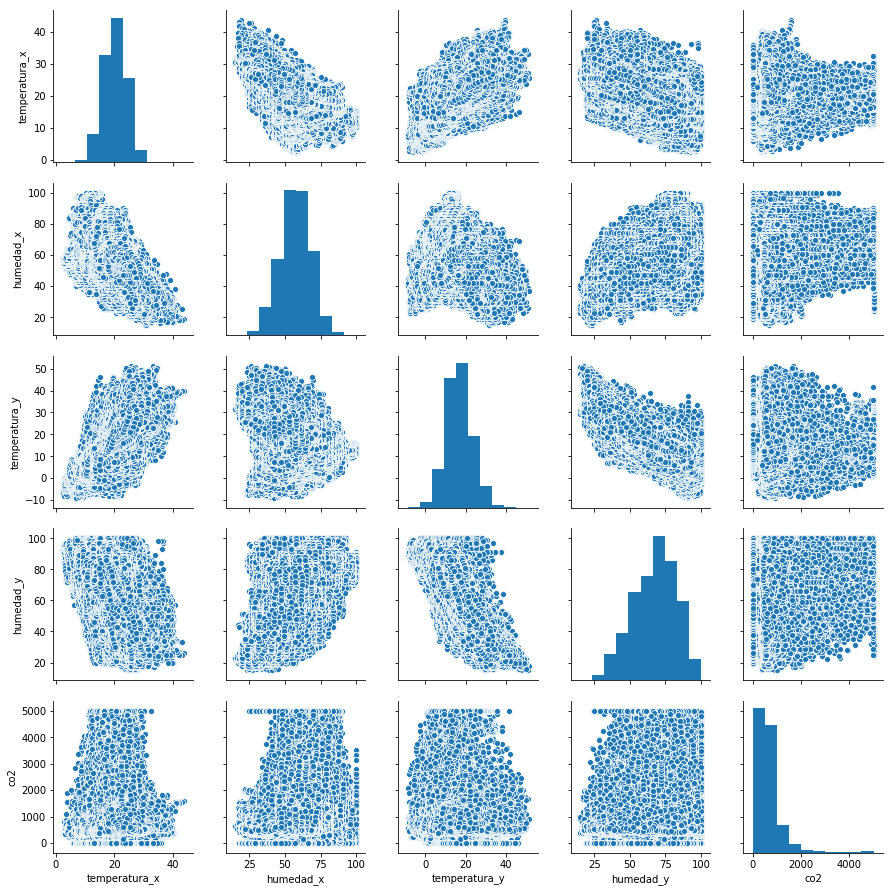

In [37]:
sns.pairplot(valid_df, vars=['temperatura_x', 'humedad_x', 'temperatura_y', 'humedad_y', 'co2'], height=2.5);

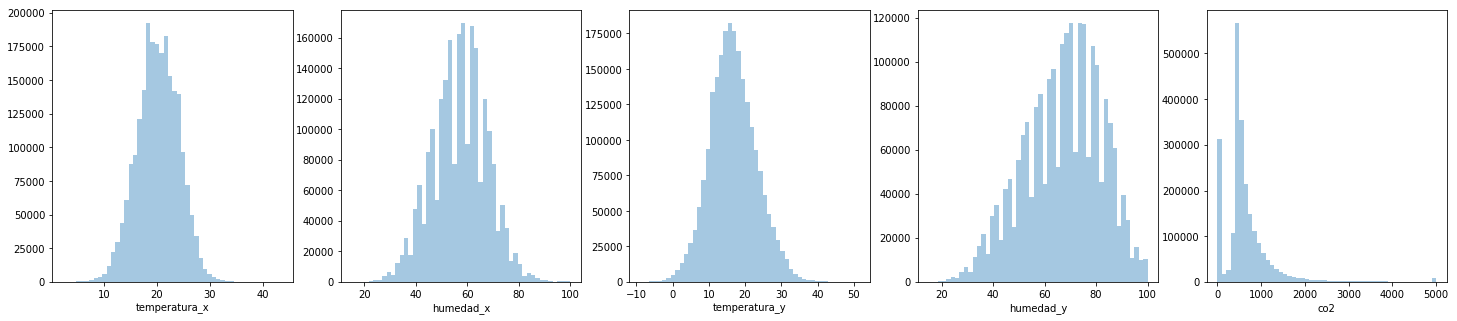

In [55]:
fig, ax = plt.subplots(1, 5, figsize=(25,5))

ax

variables = ['temperatura_x', 'humedad_x', 'temperatura_y', 'humedad_y', 'co2']

for i in range(len(variables)):
    sns.distplot(valid_df[variables[i]], hist=True, kde=False, ax=ax[i])
    
plt.show()